# 2D multi-task optimisation

This notebook shows how to run multi-task optimisation with one or two support tasks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from boss.bo.bo_main import BOMain
from utils import load_model

optimisation setup:

In [3]:
seed = 221017
num_init = 5
num_iter = 15

optimisation tasks:

In [4]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

def f_2(x):
    return unknown_model_2.predict(np.atleast_2d(x))[0]

In [5]:
unknown_model_0 = load_model('../models/model_2D_E0.npz')
unknown_model_1 = load_model('../models/model_2D_E1.npz')
unknown_model_2 = load_model('../models/model_2D_E2.npz')
bounds = [[-50.0, 310.0]] * 2

plot:

In [6]:
xp = np.linspace(-50, 310, 361)
x1, x2 = np.meshgrid(xp, xp) 
levels = 25

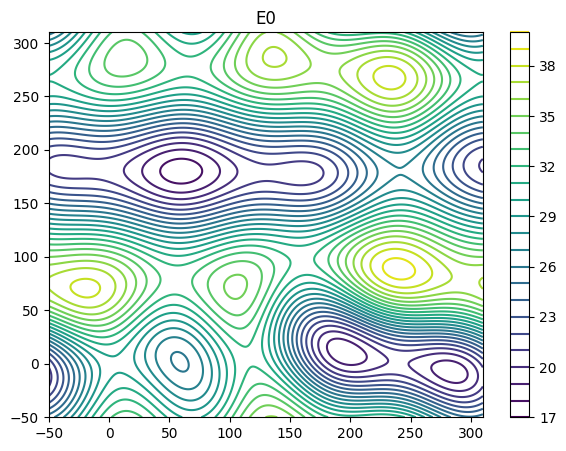

In [7]:
plt.figure(figsize=(7, 5))
yp = f_0(np.column_stack((x1.ravel(), x2.ravel())))
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E0');

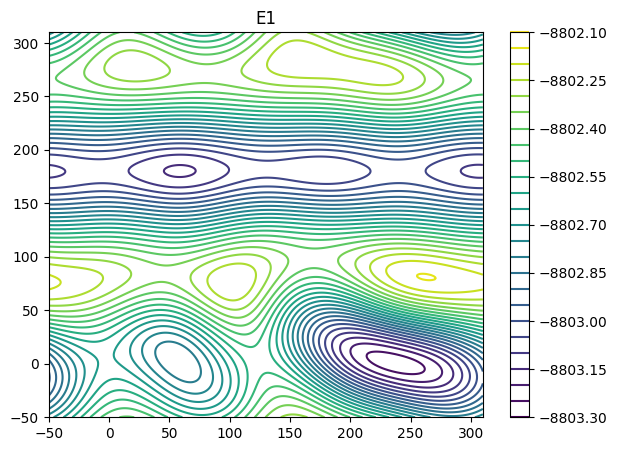

In [8]:
plt.figure(figsize=(7, 5))
yp = f_1(np.column_stack((x1.ravel(), x2.ravel())))
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E1');

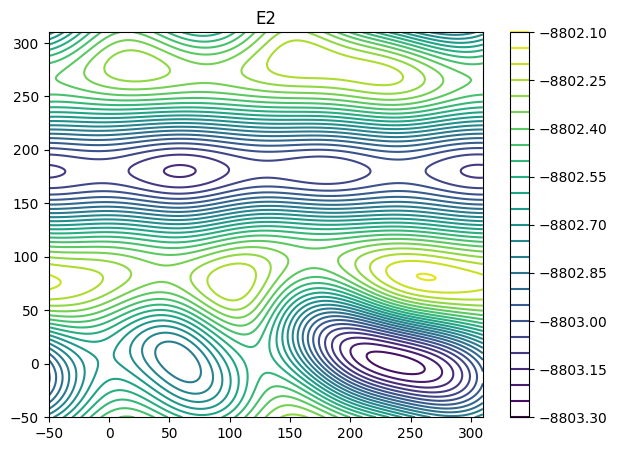

In [9]:
plt.figure(figsize=(7, 5))
yp = f_1(np.column_stack((x1.ravel(), x2.ravel())))
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E2');

## baseline optimisation

use E2 acquisitions to find the coordinates that minimise E2

In [10]:
bo_1 = BOMain(
    f_2, 
    bounds,
    yrange=[0, 1],
    kernel='stdp',
    initpts=num_init,
    iterpts=num_iter,
    minfreq=num_iter,
    seed=seed,
    outfile='boss_2D_E2.out',
    rstfile='boss_2D_E2.rst',
)

In [11]:
%time res_1 = bo_1.run()

CPU times: user 6.39 s, sys: 1.84 s, total: 8.22 s
Wall time: 5.81 s


In [12]:
res_1.get_best_acq()

(ObsAr([264.46855503,   3.08181853]), array([-8803.43185551]))

In [13]:
[res_1.select('x_glmin', -1), res_1.select('mu_glmin', -1)]

[array([248.69422769,  -0.52321385]), -8803.46471174818]

evaluate estimated minimum:

In [14]:
f_2(res_1.select('x_glmin', -1))

array([[-8803.48570342]])

plot:

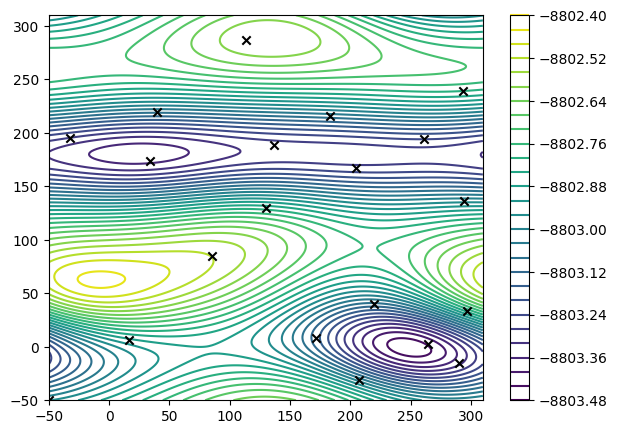

In [15]:
plt.figure(figsize=(7, 5))
yp = bo_1.model.predict(np.column_stack((x1.ravel(), x2.ravel())))[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_1.model.X[:, 0],bo_1.model.X[:, 1], marker='x', color='k', zorder=10);

## multi-task optimisation

associate acquisitions with a cost:

In [16]:
cost_0 = 0.1
cost_1 = 1
cost_2 = 2

add maximum cost limit to optimisation:

In [17]:
maxcost = (bo_1.settings["initpts"] + bo_1.settings["iterpts"]) * cost_2

### example 1

use E2 and E0 acquisitions to find the coordinates that minimise E2

In [18]:
bo_2 = BOMain(
    [f_2, f_0],
    bounds,
    kernel='stdp',
    initpts=num_init,
    iterpts=1000,
    minfreq=1000,
    maxcost=maxcost,
    acqfn_name='elcb_multi',
    task_cost=[cost_2, cost_0],
    seed=seed,
    outfile='boss_multi_2D_E2_E0.out',
    rstfile='boss_multi_2D_E2_E0.rst',
)

In [19]:
%time res_2 = bo_2.run()

CPU times: user 55.1 s, sys: 12.5 s, total: 1min 7s
Wall time: 48.8 s


In [20]:
res_2.get_best_acq()

(ObsAr([233.16353472,   2.39327081,   0.        ]), ObsAr([-8803.49070867]))

In [21]:
[res_2.select('x_glmin', -1), res_2.select('mu_glmin', -1)]

[array([231.19265903,   2.94805582,   0.        ]), -8803.490812027483]

evaluate estimated minimum:

In [22]:
f_1(res_2.select('x_glmin', -1)[:-1])

array([[-8803.27542428]])

plot:

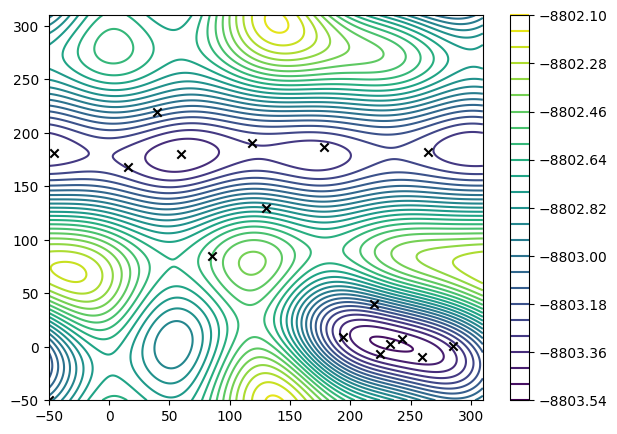

In [23]:
plt.figure(figsize=(7, 5))
yp = bo_2.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=0)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=0)[:, 0], bo_2.model.get_X(index=0)[:, 1], marker='x', color='k', zorder=10);

support task:

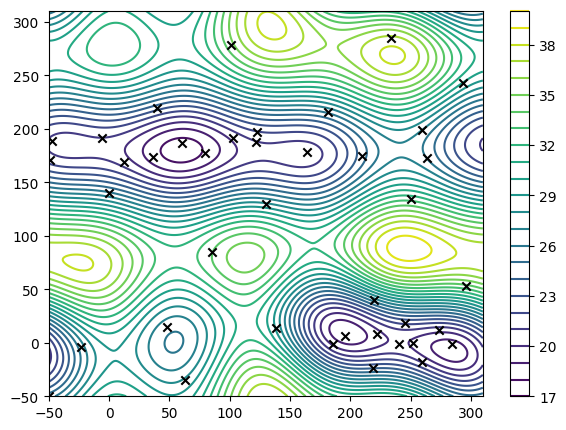

In [24]:
plt.figure(figsize=(7, 5))
yp = bo_2.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=1)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=1)[:, 0],bo_2.model.get_X(index=1)[:, 1], marker='x', color='k', zorder=10);

num evaluations:

In [25]:
dict(zip(['E2', 'E0'], np.bincount(bo_2.model.inds)))

{'E2': 17, 'E0': 40}

compare acquisitions locations:

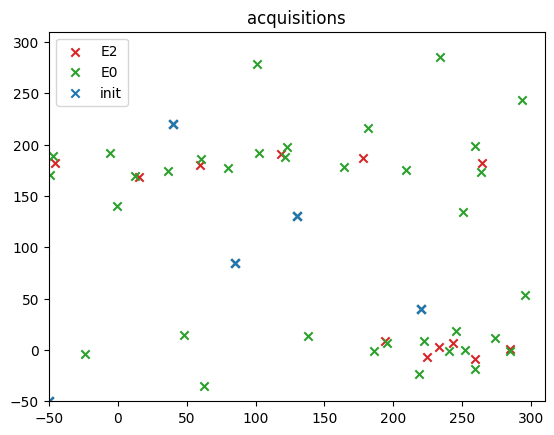

In [26]:
plt.scatter(bo_2.model.get_X(index=0)[:, 0], bo_2.model.get_X(index=0)[:, 1], marker='x',label='E2', color='C3')
plt.scatter(bo_2.model.get_X(index=1)[:, 0], bo_2.model.get_X(index=1)[:, 1], marker='x',label='E0', color='C2')
initpts=res_2.settings["initpts"]
plt.scatter(bo_2.model.X[:initpts, 0], bo_2.model.X[:initpts, 1], marker='x', label='init', color='C0')
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.legend()
plt.title('acquisitions');

### example 2

use E2-E0 acquisitions to find the coordinates that minimise E2

In [27]:
bo_3 = BOMain(
    [f_2, f_1, f_0],
    bounds,
    kernel='stdp',
    initpts=num_init,
    iterpts=1000,
    minfreq=1000,
    maxcost=maxcost,
    acqfn_name='elcb_multi',
    task_cost=[cost_2, cost_1, cost_0],
    seed=seed,
    outfile='boss_multi_2D_E2_E1_E0.out',
    rstfile='boss_multi_2D_E2_E1_E0.rst',
)

In [28]:
%time res_3 = bo_3.run()

CPU times: user 1min 39s, sys: 19.7 s, total: 1min 58s
Wall time: 1min 16s


In [29]:
res_3.get_best_acq()

(ObsAr([225.21508192,   3.25608135,   0.        ]), ObsAr([-8803.48491509]))

In [30]:
[res_3.select('x_glmin', -1), res_3.select('mu_glmin', -1)]

[array([235.08058978,   1.69469314,   0.        ]), -8803.489211741875]

evaluate estimated minimum:

In [31]:
f_2(res_3.select('x_glmin', -1)[:-1])

array([[-8803.49131232]])

plot:

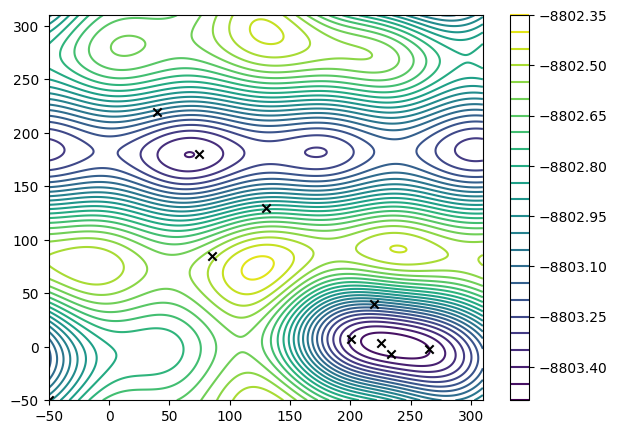

In [32]:
plt.figure(figsize=(7, 5))
yp = bo_3.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=0)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.get_X(index=0)[:, 0], bo_3.model.get_X(index=0)[:, 1], marker='x', color='k', zorder=10);

support task:

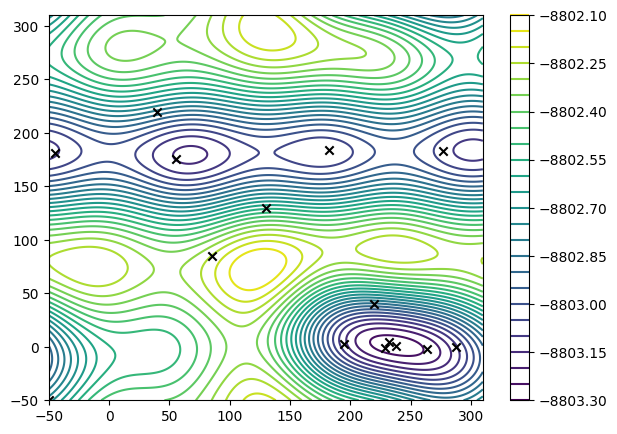

In [33]:
plt.figure(figsize=(7, 5))
yp = bo_3.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=1)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp), len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.get_X(index=1)[:, 0],bo_3.model.get_X(index=1)[:, 1], marker='x', color='k', zorder=10);

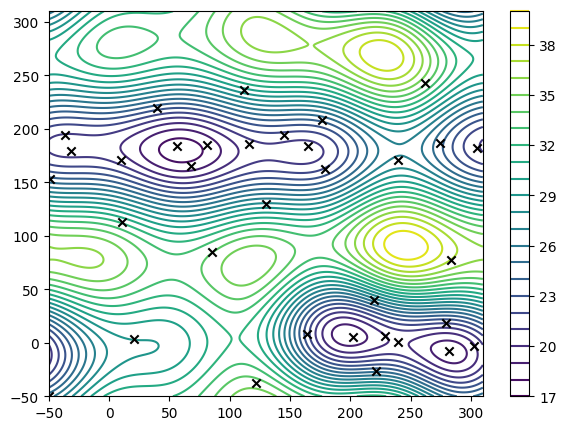

In [34]:
plt.figure(figsize=(7, 5))
yp = bo_3.model.predict(np.column_stack((x1.ravel(), x2.ravel())), index=2)[0]
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.get_X(index=2)[:, 0],bo_3.model.get_X(index=2)[:, 1], marker='x', color='k', zorder=10);

num evaluations:

In [35]:
dict(zip(['E2', 'E1', 'E0'], np.bincount(bo_3.model.inds)))

{'E2': 10, 'E1': 15, 'E0': 34}

compare acquisition locations:

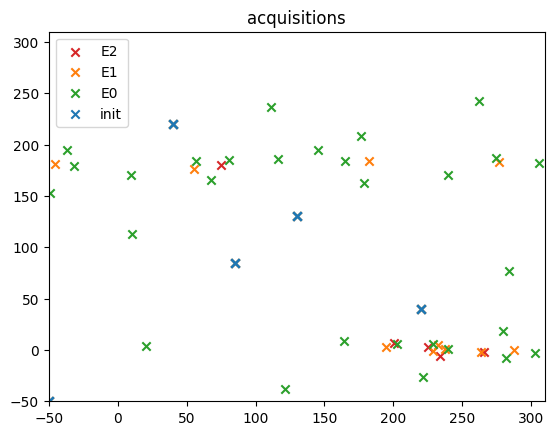

In [36]:
plt.scatter(bo_3.model.get_X(index=0)[:, 0], bo_3.model.get_X(index=0)[:, 1], marker='x',label='E2', color='C3')
plt.scatter(bo_3.model.get_X(index=1)[:, 0], bo_3.model.get_X(index=1)[:, 1], marker='x',label='E1', color='C1')
plt.scatter(bo_3.model.get_X(index=2)[:, 0], bo_3.model.get_X(index=2)[:, 1], marker='x',label='E0', color='C2')
initpts=res_3.settings["initpts"]
plt.scatter(bo_3.model.X[:initpts, 0], bo_3.model.X[:initpts, 1], marker='x', label='init', color='C0')
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.legend()
plt.title('acquisitions');

compare optimisation outcomes:

In [37]:
f_2(res_1.select('x_glmin', -1))

array([[-8803.48570342]])

In [38]:
f_2(res_2.select('x_glmin', -1)[:-1])

array([[-8803.48981619]])

In [39]:
f_2(res_3.select('x_glmin', -1)[:-1])

array([[-8803.49131232]])